In [1]:
#!/usr/bin/env python3
import pandas as pd
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
import baltic as bt
from matplotlib.lines import Line2D

# set to arial
plt.rcParams['font.sans-serif'] = "Arial"

# load data

In [2]:
# Load and preprocess OWID data
owid_data = pd.read_csv('../data/owid-monkeypox-data.csv')
owid_data['date'] = pd.to_datetime(owid_data['date'])
owid_data = owid_data[owid_data['location'].isin(['United States', 'World'])]

# Define date range
earliest_date, latest_date = '2022-04-28', '2023-04-28'

# Extend, fill, and prepare US data from OWID
us_data = owid_data.loc[owid_data['location'] == 'United States']
# print cumulative USA cases by 2023-04-28

us_data = us_data.set_index('date').reindex(pd.date_range(start=earliest_date, end=latest_date)).fillna(0).reset_index().rename(columns={'index': 'date', 'new_cases': 'cases'})
us_data['location'], us_data['iso_code'] = 'United States', 'USA'

# Prepare World data
world_data = owid_data.loc[owid_data['location'] == 'World', ['location', 'date', 'new_cases']].rename(columns={'new_cases': 'cases'})
world_data['date'] = pd.to_datetime(world_data['date'])
world_data = world_data.set_index('date').reindex(pd.date_range(start=earliest_date, end=latest_date)).fillna(0).reset_index().rename(columns={'index': 'date'})
world_data['location'] = 'World'

# Load and preprocess NYC data
case_counts = pd.read_csv('../data/nyc_case_counts.csv')
case_counts.columns = ['date', 'cases']
case_counts['date'] = pd.to_datetime(case_counts['date'])
case_counts = case_counts.set_index('date').reindex(pd.date_range(start=earliest_date, end=latest_date)).fillna(0).reset_index().rename(columns={'index': 'date'})
case_counts['location'] = 'NYC'

# Function to convert to weekly data
def convert_to_weekly(df, col='cases'):
    df_weekly = df.set_index('date')[col].resample('W').sum().reset_index()
    df_weekly['location'] = df['location'].iloc[0]
    return df_weekly


# Function to convert to monthly data 
def convert_to_monthly(df, col='cases'):
    df_monthly = df.set_index('date')[col].resample('M').sum().reset_index()
    df_monthly['location'] = df['location'].iloc[0]
    return df_monthly


# Applying conversion to weekly data
us_weekly = convert_to_weekly(us_data)
world_weekly = convert_to_weekly(world_data)
nyc_weekly = convert_to_weekly(case_counts)
nyc_monthly = convert_to_monthly(case_counts)

# Assuming us_weekly and nyc_weekly are DataFrames with 'date' and 'cases' columns
# First, ensure both DataFrames are sorted by date
us_weekly.sort_values('date', inplace=True)
nyc_weekly.sort_values('date', inplace=True)
nyc_monthly.sort_values('date', inplace=True)

# Iterate through nyc_weekly to find and adjust discrepancies in us_weekly
for index, row in nyc_weekly.iterrows():
    nyc_date = row['date']
    nyc_cases = row['cases']
    us_cases = us_weekly.loc[us_weekly['date'] == nyc_date, 'cases'].iloc[0]

    # Check if adjustment is needed
    if us_cases < nyc_cases:
        difference = nyc_cases - us_cases
        # Increase us_weekly cases for this date
        us_weekly.loc[us_weekly['date'] == nyc_date, 'cases'] += difference
        
        # Find a later date to decrease
        # This example simply picks the next date with sufficient cases, but you might need a more sophisticated approach
        for i, later_index in enumerate(us_weekly[us_weekly['date'] > nyc_date].index):
            if us_weekly.at[later_index, 'cases'] > difference:
                us_weekly.at[later_index, 'cases'] -= difference
                break  # Stop after adjusting the first suitable later date
# Note: This example assumes there's always a "later date" with enough cases to adjust.
# In practice, you might need to handle cases where no suitable later date exists or implement a more sophisticated logic for selecting the date to decrement.

# adjust world data to be world data minus us data
world_weekly['cases'] = world_weekly['cases'] - us_weekly['cases'].values

# adjust us data to be us data minus nyc data
us_weekly['cases'] = us_weekly['cases'] - nyc_weekly['cases'].values

# get cumulative cases for each location
us_weekly['cumulative_cases'] = us_weekly['cases'].cumsum()
world_weekly['cumulative_cases'] = world_weekly['cases'].cumsum()
nyc_weekly['cumulative_cases'] = nyc_weekly['cases'].cumsum()
nyc_monthly['cumulative_cases'] = nyc_monthly['cases'].cumsum()

# Concatenate the data
weekly_data = pd.concat([us_weekly, world_weekly, nyc_weekly])
weekly_data['date_str'] = weekly_data['date'].astype(str)
weekly_data['date_float'] = weekly_data['date_str'].apply(lambda x: toYearFraction(x))
weekly_data = weekly_data.sort_values(['location', 'date'])
# replace World with Global
weekly_data['location'] = weekly_data['location'].replace('World', 'Global')

monthly_data = nyc_monthly.copy()
monthly_data['date_str'] = monthly_data['date'].astype(str)
monthly_data['date_float'] = monthly_data['date_str'].apply(lambda x: toYearFraction(x))

metadata_path = '../../data/global_B.1_withOutgroup.metadata.updated.tsv'
metadata_path = '../../data/metadata_combined.nycFiltered.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')
metadata.columns = ['strain', 'date', 'location']

metadata = metadata[metadata['date'] >= earliest_date]
metadata = metadata[metadata['date'] <= latest_date]
metadata['date'] = pd.to_datetime(metadata['date'])
loc_date_counts = metadata.groupby(['location', 'date']).size()
loc_date_counts = loc_date_counts.reset_index()
loc_date_counts.columns = ['location', 'date', 'genomes']

# fill in missing dates with 0 counts, set from 2022-05-01 to 2023-06-01
def fill_missing_dates(df, earliest_date, latest_date):
    loc = df['location'].values[0]
    date_range = pd.date_range(start=earliest_date, end=latest_date)
    date_range = pd.DataFrame(date_range, columns=['date'])
    date_range['date'] = pd.to_datetime(date_range['date'])
    date_range['date'] = date_range['date'].dt.date
    date_range['date'] = pd.to_datetime(date_range['date'])
    date_range['location'] = loc
    date_range['genomes'] = 0
    date_range = date_range.set_index(['location', 'date'])
    df = df.set_index(['location', 'date'])
    df = df.reindex(date_range.index, fill_value=0).reset_index()
    return df


loc_date_counts_nyc = fill_missing_dates(loc_date_counts[loc_date_counts['location'] == 'NYC'], earliest_date, latest_date)
loc_date_counts_us = fill_missing_dates(loc_date_counts[loc_date_counts['location'] == 'USA'], earliest_date, latest_date)
loc_date_counts_global = fill_missing_dates(loc_date_counts[loc_date_counts['location'] == 'Global'], earliest_date, latest_date)

loc_date_counts_nyc_weekly = convert_to_weekly(loc_date_counts_nyc, col='genomes')
loc_date_counts_us_weekly = convert_to_weekly(loc_date_counts_us, col='genomes')
loc_date_counts_global_weekly = convert_to_weekly(loc_date_counts_global, col='genomes')
loc_date_counts_nyc_monthly = convert_to_monthly(loc_date_counts_nyc, col='genomes')

loc_date_counts_nyc_weekly['cumulative_genomes'] = loc_date_counts_nyc_weekly['genomes'].cumsum()
loc_date_counts_us_weekly['cumulative_genomes'] = loc_date_counts_us_weekly['genomes'].cumsum()
loc_date_counts_global_weekly['cumulative_genomes'] = loc_date_counts_global_weekly['genomes'].cumsum()
loc_date_counts_nyc_monthly['cumulative_genomes'] = loc_date_counts_nyc_monthly['genomes'].cumsum()

# concatenate the data
loc_date_counts_weekly = pd.concat([loc_date_counts_nyc_weekly, loc_date_counts_us_weekly, loc_date_counts_global_weekly])
loc_date_counts_weekly['location'] = loc_date_counts_weekly['location'].replace('USA', 'United States')

# merge the data
weekly_data = weekly_data.merge(loc_date_counts_weekly, on=['location', 'date'], how='left')
monthly_data = monthly_data.merge(loc_date_counts_nyc_monthly, on=['location', 'date'], how='left')

weekly_data['prop_sequenced'] = weekly_data['genomes'] / weekly_data['cases']
weekly_data['cumulative_prop_sequenced'] = weekly_data['cumulative_genomes'] / weekly_data['cumulative_cases']
weekly_data.fillna(0, inplace=True)
# weekly_data[weekly_data['location'] == 'United States']

monthly_data['prop_cases_sequenced'] = monthly_data['genomes'] / monthly_data['cases']
monthly_data = monthly_data.fillna(0)
monthly_data['prop_cases_sequenced'] = monthly_data['prop_cases_sequenced'].apply(lambda x: round(x, 2))
monthly_data['prop_infections_sequenced'] = monthly_data['prop_cases_sequenced'].apply(lambda x: str(round(x*0.6, 2)) + ' (' + str(round(x*0.4, 2)) + '-' + str(round(x*0.9, 2)) + ')')
monthly_data['month'] = monthly_data['date'].apply(lambda x: str(x.month) + '/' + str(x.year))

# Plot

/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

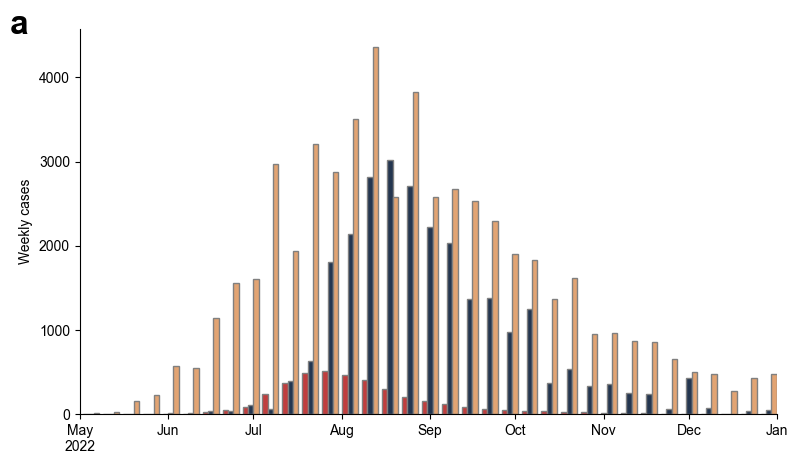

In [3]:
cmap = ['#d62828', '#1d3557', '#f4a261', '#2a9d8f']

start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-01-01')

# Generate a date range that covers the entire period of your dataset
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS' stands for Month Start
date_range_str = [date.strftime('%Y-%m-%d') for date in date_range]  # Formatting the x-tick labels
date_range_xticks = [(toYearFraction(date)-toYearFraction(earliest_date))*365/7 for date in date_range_str]  # Converting the x-tick labels to float
date_range_xlabels = [date.strftime('%b\n%Y') for date in date_range]  # Formatting the x-tick labels
date_range_xlabels = [date.strftime('%b') for date in date_range]  # Formatting the x-tick labels
date_range_xlabels[0] += '\n2022'

# Plotting
plt.figure(figsize=(9, 5))  # Customize figure size
t_ax = sns.barplot(data=weekly_data, x='date_float', y='cases', hue='location', palette=cmap, dodge=True, edgecolor='grey', width=.8)

xticks = plt.xticks()[0]
# Customize x-ticks
plt.xticks(date_range_xticks, date_range_xlabels, ha='center')
plt.xlim(date_range_xticks[0], date_range_xticks[-1])
plt.xlabel(None)
plt.ylabel('Weekly cases')

# remove legend
plt.legend().remove()
# remove upper and right borderline
sns.despine()

# add panel label
plt.text(-0.1, 1.05, 'a', transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top')

plt.show()

/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanpekar/opt/mambaforge/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

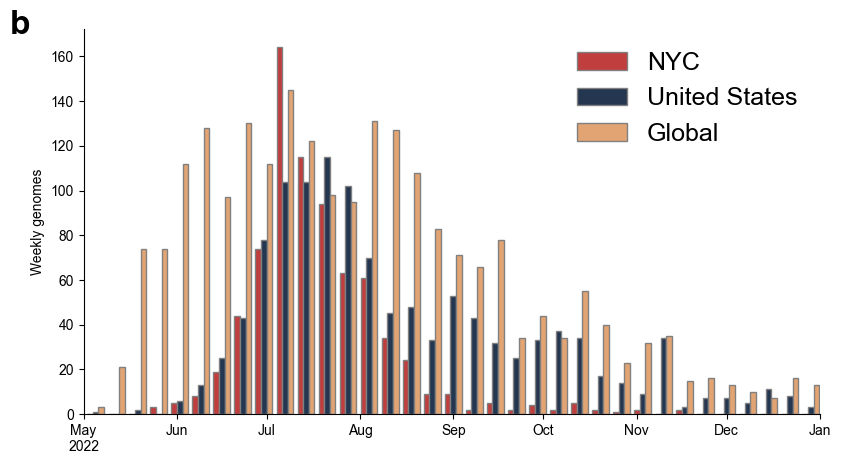

In [4]:
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS' stands for Month Start
date_range_str = [date.strftime('%Y-%m-%d') for date in date_range]  # Formatting the x-tick labels
date_range_xticks = [(toYearFraction(date)-toYearFraction(earliest_date))*365/7 for date in date_range_str]  # Converting the x-tick labels to float
date_range_xlabels = [date.strftime('%b') for date in date_range]  # Formatting the x-tick labels
date_range_xlabels[0] += '\n2022'

plt.figure(figsize=(9.5, 5))  # Customize figure size
sns.barplot(data=weekly_data, x='date', y='genomes', hue='location', palette=cmap, dodge=True, edgecolor='grey', width=0.8)
xticks = plt.xticks()[0]
# Customize x-ticks
plt.xticks(date_range_xticks, date_range_xlabels, ha='center')
plt.xlim(date_range_xticks[0], date_range_xticks[-1])

plt.xlabel(None)
plt.ylabel('Weekly genomes')

# remove title and borderline from legend
plt.legend(title=None, frameon=False, loc='upper right', fontsize=18)
# remove upper and right borderline
sns.despine()

# add panel label
plt.text(-0.1, 1.05, 'b', transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top')

plt.show()

# Plot tree


Tree height: 1.371708
Tree length: 668.457056
strictly bifurcating tree
annotations present

Numbers of objects in tree: 8087 (4043 nodes and 4044 leaves)



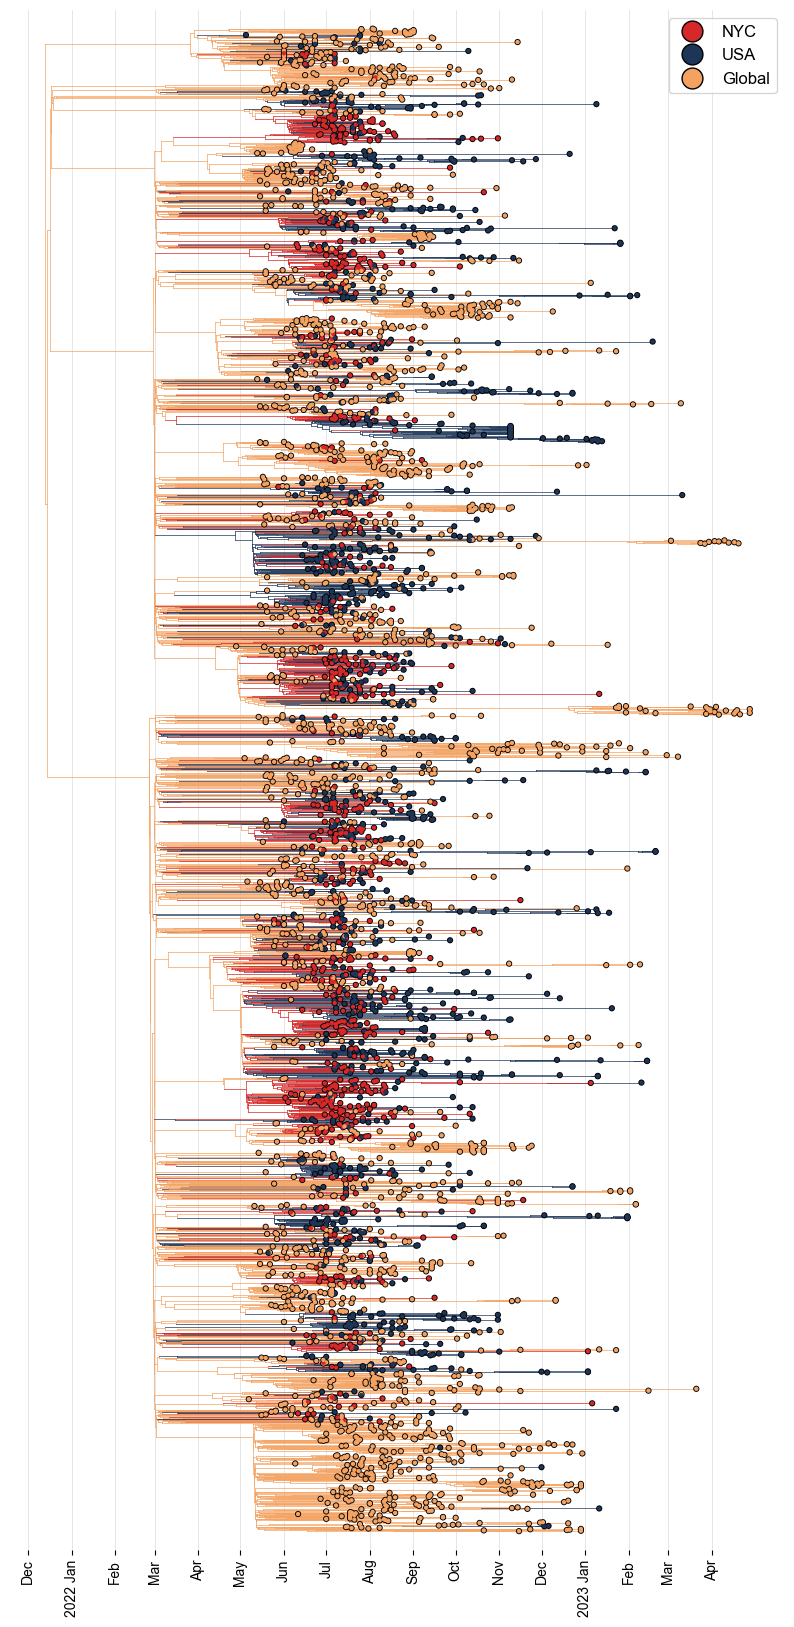

In [5]:
cset = {"NYC" : cmap[0],
        "USA" : cmap[1],
        "nonUSA" : cmap[2]}

c_func = lambda k: cset.get( k.traits['loc.states'], "k" )

mcc_sep_tree_path = '../phylogenetics/global_B.1.empirical.dta.mcc.tree'
treeFile = mcc_sep_tree_path
ll=bt.loadNexus(treeFile) ## treeFile here can alternatively be a path to a local file
ll.treeStats() ## report stats about tree

fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

x_attr=lambda k: k.absoluteTime

ll.plotTree(ax,x_attr=x_attr,colour=c_func, width=0.5, zorder=10) ## tree
ll.plotPoints(ax,x_attr=x_attr,colour=c_func,size=10, zorder=100) ## tips

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylim(-50,ll.ySpan+50)

# every month starting from 2022 until 2023
dates = ['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01']
# have labels as months, except for january 
labels = ['Dec', '2022 Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2023 Jan', 'Feb', 'Mar', 'Apr']

ax.set_xticks([toYearFraction(x) for x in dates])
ax.set_xticklabels(labels, rotation=90, ha='center')

# change color of gridlines
ax.grid(color='gainsboro', linestyle='-', linewidth=0.5)

# remove 
[ax.spines[loc].set_visible(False) for loc in ax.spines]

custom_legend = [
                Line2D([0], [0], marker='o', color='w', label='NYC', markerfacecolor=cset.get('NYC'), markeredgecolor="#000000", markersize=15),
                Line2D([0], [0], marker='o', color='w', label='USA', markerfacecolor=cset.get('USA'), markeredgecolor="#000000", markersize=15),
                Line2D([0], [0], marker='o', color='w', label='Global', markerfacecolor=cset.get('nonUSA'), markeredgecolor="#000000", markersize=15)
                ]

ax.legend(handles = custom_legend, loc='upper right', fontsize='large')

plt.show()